<img style="float: right; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="300" height="400" /> 
    
    
### <font color='navy'> Modelos no Lineales para Pronósticos. </font>

**Nombres:**
> `Cárdenas Gallardo Paula Daniela` | `733720` <br> `Haces López José Manuel` | `734759` <br> `Villa Domínguez Paulo Adrián` | `733773`

**Fecha:** Mayo 2023
    
**Profesor:** Óscar David Jaramillo Zuluaga.
    
**Link Github**: [github.com](https://github.com/paucardenasg/Proyecto_MNLP)

# <font color='maroon'> Proyecto Final </font>

In [1]:
# Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Carga de datos
data = pd.read_csv('./Data/dataset.csv')
# Eliminando la columna de index y Unit
data.drop(columns=['SN', 'Unit'], inplace=True)
# Poniendo el date a formato de fecha
data['Date'] = pd.to_datetime(data['Date'])
# Poniendo la fecha como str
data['Fecha_Str'] = data['Date'].dt.strftime('%Y-%m-%d')
# Cambiando el nombre de las columnas a español
data.rename(columns={'Date':'Fecha', 'Commodity':'Producto', 'Minimum':'Mínimo', 'Maximum':'Máximo', 'Average':'Promedio'}, inplace=True)

# --------------------------------------------------------------------------------------------------------------------

# Cargando el dataset del cambio de Rupia Nepali a Pesos
data_cambio = pd.read_excel('./Data/CambioMoneda.xlsx')
# Poniendo Fecha en formato de fech
data_cambio['Fecha'] = pd.to_datetime(data_cambio['Fecha'])
# Quitando la hora de la fecha
data_cambio['Fecha'] = data_cambio['Fecha'].dt.date
# Poniendo la fecha como str
data_cambio['Fecha_Str'] = data_cambio['Fecha'].astype(str)

# --------------------------------------------------------------------------------------------------------------------

# Obtener las clases de productos
productos_clase = data[['Producto']]
productos_clase = productos_clase.drop_duplicates()
# Tomar solo la primera palabra del valor de la columna de producto
productos_clase['Clase'] = productos_clase['Producto'].str.split(' ').str[0]
productos_clase['Clase'] = productos_clase['Clase'].str.split('(').str[0]

# Mergeando los datos con la clase de producto
data = data.merge(productos_clase, on='Producto')

# --------------------------------------------------------------------------------------------------------------------

# Juntando los dos datasets de tipo de cambio a pesos
data = data.merge(data_cambio.drop(columns=['Fecha']), on='Fecha_Str')

# --------------------------------------------------------------------------------------------------------------------

# Dataset con el precio del dolar
dolar = pd.read_excel('./Data/PrecioDolar.xlsx')
dolar['Fecha'] = pd.to_datetime(dolar['Fecha'])
# Quitando la hora de la fecha
dolar['Fecha'] = dolar['Fecha'].dt.date
# Poniendo la fecha como str
dolar['Fecha_Str'] = dolar['Fecha'].astype(str)

# Mergeando los datos con el precio del dolar
data = data.merge(dolar.drop(columns=['Fecha']), on='Fecha_Str')

# --------------------------------------------------------------------------------------------------------------------

# Multiplicando el precio por el cambio de moneda
data['Mínimo'] = np.round(data['Mínimo'] * data['Valor'], decimals=4)
data['Máximo'] = np.round(data['Máximo'] * data['Valor'], decimals=4)
data['Promedio'] = np.round(data['Promedio'] * data['Valor'], decimals=4)
# Eliminar la columna de valor
data.drop(columns=['Valor'], inplace=True)

# --------------------------------------------------------------------------------------------------------------------

# Sacando una columna con el año
data['Year'] = data['Fecha'].dt.year

# Dataset con la inflación
inflacion = pd.read_excel('./Data/Inflacion.xlsx')
data = data.merge(inflacion, on='Year')

# --------------------------------------------------------------------------------------------------------------------

# Agregando el porcentaje de desempleo
desempleo = pd.read_excel('./Data/Desempleo.xlsx')
data = data.merge(desempleo, on='Year')

# --------------------------------------------------------------------------------------------------------------------

# Poniendo la fecha como indice
data.set_index('Fecha', inplace=True)

# Ordenando los datos por fecha y por producto
data.sort_values(by=['Fecha', 'Producto'], inplace=True)

# --------------------------------------------------------------------------------------------------------------------

# Ordenando las columnas
data = data[['Producto', 'Clase', 'Mínimo', 'Máximo', 'Promedio', 'Inflacion', 'Precio_Dolar', 'Desempleo']]

data.head()

,Producto,Clase,Mínimo,Máximo,Promedio,Inflacion,Precio_Dolar,Desempleo
Fecha,,,,,,,,
2013-06-16,Apple(Jholey),Apple,13.6746,16.4096,15.0421,9.04,90.456,10.5
2013-06-16,Asparagus,Asparagus,13.6746,20.5120,17.0933,9.04,90.456,10.5
2013-06-16,Bamboo Shoot,Bamboo,6.8373,8.2048,7.5211,9.04,90.456,10.5
2013-06-16,Banana,Banana,9.5723,10.9397,10.2560,9.04,90.456,10.5
2013-06-16,Bitter Gourd,Bitter,1.9145,2.1879,2.0512,9.04,90.456,10.5


## EDA

In [3]:
# Mostrando fechas de inicio y fin de los datos, puras fechas sin hora
print('Fecha de inicio: ', data.index.min().date())
print('Fecha de fin: ', data.index.max().date())

Fecha de inicio:  2013-06-16
Fecha de fin:  2021-05-11


In [4]:
# Productos
tipos_de_productos = data['Producto'].unique()
print(f'Cantidad de Productos: {len(tipos_de_productos)}')

Cantidad de Productos: 132


In [5]:
# Porcentaje que representa cada producto
porcentaje = data['Producto'].value_counts(normalize=True).reset_index().sort_values(by='Producto', ascending=False)
# Multiplicando por 100 para obtener el porcentaje
porcentaje['Producto'] = np.round(porcentaje['Producto'] * 100, decimals=3)
# Haciendo una suma acumulativa
porcentaje['Cum_Sum'] = porcentaje['Producto'].cumsum()
porcentaje.rename(columns={'index': 'Producto', 'Producto': 'Porcentaje'}, inplace=True)
porcentaje

,Producto,Porcentaje,Cum_Sum
0,Ginger,1.385,1.385
1,Cauli Local,1.385,2.770
2,Cabbage(Local),1.384,4.154
3,Chilli Dry,1.384,5.538
4,Raddish White(Local),1.384,6.922
...,...,...,...
127,Maize,0.013,99.975
128,Mango(Calcutte),0.012,99.987
129,Sweet Lime,0.008,99.995
130,Musk Melon,0.004,99.999


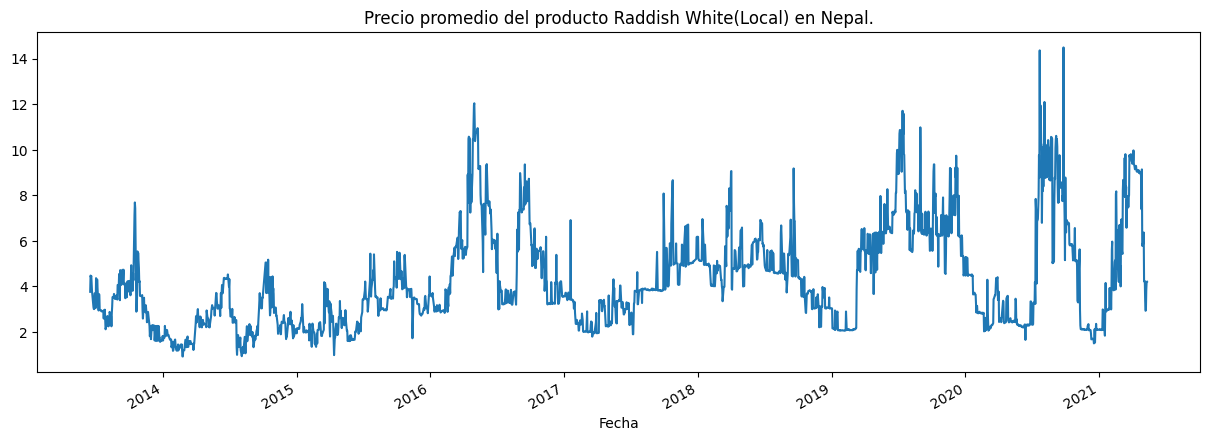

In [6]:
# Poniendo un seed para que siempre se obtenga el mismo resultado
np.random.seed(21)

# Random choice para seleccionar un producto al azar
producto = np.random.choice(tipos_de_productos)

# Graficando el promedio del producto seleccionado
data[data['Producto'] == producto]['Promedio'].plot(figsize=(15, 5), title=f'Precio promedio del producto {producto} en Nepal.')
plt.show()